In [28]:
import warnings
warnings.filterwarnings("ignore")
import pyart
import numpy as np
from pyart.retrieve import get_freq_band
from matplotlib import pyplot as plt
import glob, os
from datetime import datetime
import time
import xarray as xr
import pandas as pd
# from pymeso import llsd
# import scipy

In [2]:
import sys
sys.path.append("../")
import nearest_nexrad as nrnx

In [3]:
nrnx.nearest_sites(33.75801, -88.44617, 1)

,ID,lat,lon,elev,distance
63,KGWX,33.89667,-88.32889,476.0,0.181607


In [4]:
def _drop_fields(radar):
    fields_to_drop = ["PURPLE_HAZE"]
    for field in fields_to_drop:
        if field in radar.fields:
            del radar.fields[field]
    return radar

In [5]:
#function to dealiase the Doppler velocity
def dealiase(radar, vel_name='velocity', gatefilter=None, method="unwrap"):
    '''
    Dealias Doppler velocities using Py-ART.
    method : str
        Method to use for the dealiasing. Can be 'unwrap' or 'region'.
    '''
    # Create a GateFilter if one was not provided
    if gatefilter is None:
        gatefilter = pyart.correct.GateFilter(radar)
        gatefilter.include_above("REF", 0)
        gatefilter.exclude_masked('REF')
        gatefilter.exclude_invalid('REF')
        gatefilter.exclude_transition()
    # Dealias Doppler velocities using the selected method
    if method == "unwrap":
        corr_vel = pyart.correct.dealias_unwrap_phase(radar, vel_field=vel_name,
                                                      keep_original=False, gatefilter=gatefilter)
    elif method == "region":
        corr_vel = pyart.correct.dealias_region_based(radar, vel_field=vel_name,
                                                      keep_original=False, gatefilter=gatefilter)
    # Add the dealiased Doppler velocities to the radar object
    radar.add_field(vel_name, corr_vel, replace_existing=True)
    return radar

In [6]:
def filter_data(radar, refl_field, vel_field, dealias_method="region"):
    '''Remove noise based on velocity texture,snr, and rhohv, and mask all the fields'''
    # Drop some fields
    radar = _drop_fields(radar)
    # Align radar coords
    radar.scan_type = b'ppi'
    # Dealias
    radar = dealiase(radar, vel_name=vel_field, gatefilter=None, method=dealias_method)
    
    return radar

In [7]:
def get_nexrad_data_files(start_time: str, end_time: str) -> list:
    '''start_time: str ('YYYYMMDDHHMMSS')
       end_time: str ('YYYYMMDDHHMMSS')'''
    
    start_datetime = datetime.strptime(start_time, '%Y%m%d%H%M%S')
    end_datetime = datetime.strptime(end_time, '%Y%m%d%H%M%S')
    
    nexrad_dir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/NEXRAD/"
    radar_site = ['KGWX']
    data_files = []
    for iop in ["IOP2"]:
        for radar_name in radar_site:
            data_files.extend(sorted(glob.glob(f"{nexrad_dir}{iop}/{radar_name}/*V06.nc")))
    
    data_files_filtered = []
    for file in data_files:
#         print(file.split('/')[-1].split("KGWX")[1].split("_V")[0])
        file_datetime_str = file.split('/')[-1].split("KGWX")[1].split("_V")[0]
        file_datetime = datetime.strptime(file_datetime_str, '%Y%m%d_%H%M%S')
        if start_datetime <= file_datetime < end_datetime:
            data_files_filtered.append(file)
    
    print("Available files: ", len(data_files_filtered))
#     for file in data_files_filtered:
#         print(file.split("/")[-1])
        
    return data_files_filtered

In [8]:
data_files = get_nexrad_data_files("20220330220000", "20220331040000")

Available files:  54


## IOP2 PIPS Summary
    PIPS1A 2349-0126 UTC 33.75801/-88.44617/71
    PIPS1B 2341-0134 UTC 33.71500/-88.45050/67
    PIPS2A 2359-0112 UTC 33.82967/-88.45933/74
    PIPS3B 2359-0115 UTC 33.82967/-88.45933/74

In [9]:
for rfile in data_files[:1]:
    print(f'Reading file: {rfile.split("/")[-1]}')
    radar = pyart.io.read(rfile)

Reading file: KGWX20220330_220424_V06.nc


In [11]:
def plot_radar(radar):
    fig = plt.figure(figsize=(12, 4))
    display = pyart.graph.RadarMapDisplay(radar)
    ax = plt.subplot(121)
    display.plot_ppi("REF", sweep=0, vmin=-10, vmax = 80, cmap="pyart_HomeyerRainbow", ax=ax, fig=fig)
    ax.set_xlim([-350,350])
    ax.set_ylim([-350,350])
    ax = plt.subplot(122)
    display.plot_ppi("VEL", sweep=0, ax=ax, fig=fig, vmin=-50, vmax=50, cmap="pyart_NWSVel")
    ax.set_xlim([-350,350])
    ax.set_ylim([-350,350])
    plt.show()

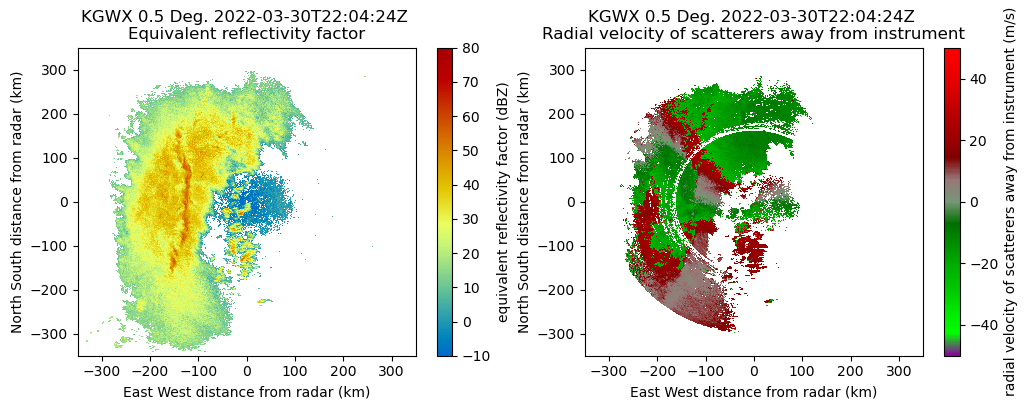

In [12]:
plot_radar(radar)

In [13]:
radar = filter_data(radar, "DBZ", "VEL")

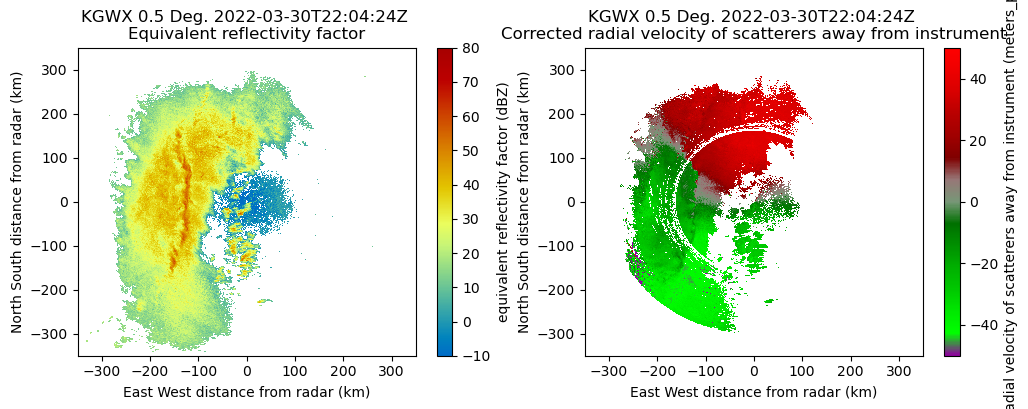

In [14]:
plot_radar(radar)

In [15]:
radar.fields.keys()

dict_keys(['REF', 'VEL', 'SW', 'ZDR', 'PHI', 'RHO'])

In [25]:
15000./60, -360.*1e3/-720.0, 

(250.0, 500.0)

In [83]:
def calc_num_elements(start, stop, num):
    step = ((stop - start) - 1) / num
    return step

In [85]:
calc_num_elements(0, 15000, 250)

59.996

In [11]:
def linspace_range(start, stop, step):
    num = int((stop - start) / step + 1)
    return num

In [31]:
linspace_range(0, 15000, 250), linspace_range(0, 200*1e3*2, 500)

(61, 801)

In [20]:
max_rng = 200.0*1e3 # np.ceil(radar.range['data'].max())
grid = pyart.map.grid_from_radars(radar,(61,801,801),
                   ((0.,15e3),(-max_rng, max_rng),(-max_rng, max_rng)), 
                                   weighting_function='Barnes2',
                                  fields=['REF', 'VEL', 'ZDR', "RHO"])

In [27]:
np.diff(grid.x['data'])

array([500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 50

In [29]:
xg = grid.to_xarray()

In [50]:
xg['REF'].z

<xarray.DataArray 'z' (z: 60)>
array([    0.      ,   254.237288,   508.474576,   762.711864,  1016.949153,
        1271.186441,  1525.423729,  1779.661017,  2033.898305,  2288.135593,
        2542.372881,  2796.610169,  3050.847458,  3305.084746,  3559.322034,
        3813.559322,  4067.79661 ,  4322.033898,  4576.271186,  4830.508475,
        5084.745763,  5338.983051,  5593.220339,  5847.457627,  6101.694915,
        6355.932203,  6610.169492,  6864.40678 ,  7118.644068,  7372.881356,
        7627.118644,  7881.355932,  8135.59322 ,  8389.830508,  8644.067797,
        8898.305085,  9152.542373,  9406.779661,  9661.016949,  9915.254237,
       10169.491525, 10423.728814, 10677.966102, 10932.20339 , 11186.440678,
       11440.677966, 11694.915254, 11949.152542, 12203.389831, 12457.627119,
       12711.864407, 12966.101695, 13220.338983, 13474.576271, 13728.813559,
       13983.050847, 14237.288136, 14491.525424, 14745.762712, 15000.      ])
Coordinates:
  * z        (z) float64 0.0 254.2 508.5 762.7 ... 1.449e+04 1.475e+04 1.5e+04
Attributes:
    standard_name:  projection_z_coordinate
    long_name:      Z distance on the projection plane from the origin
    axis:           Z
    units:          m
    positive:       up

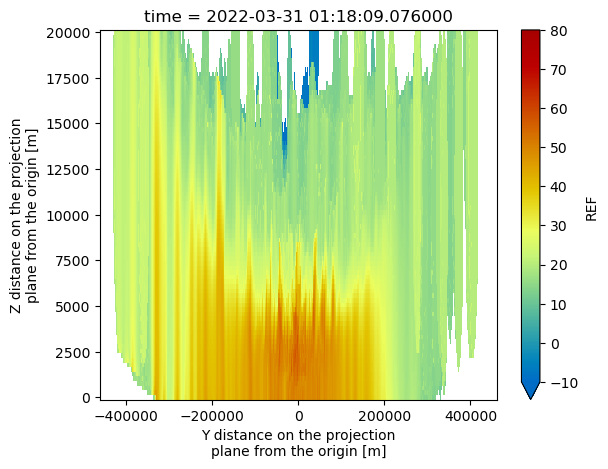

In [184]:
xg['REF'].max('x').plot(vmin=-10, vmax = 80, 
                     cmap="pyart_HomeyerRainbow", 
                     
                    )

In [135]:
do not run this cell directly here
import multiprocessing
from functools import partial

# Define a function that takes a file name and writes the GRID file
def process_file(nexrad_dir, rfile):
    radar = pyart.io.read(rfile)
    radar = filter_data(radar, "DBZ", "VEL")
    max_rng = 360.*1e3 # np.ceil(radar.range['data'].max())
    grid = pyart.map.grid_from_radars(radar,(60,720,720),
                       ((0.,15000.),(-max_rng, max_rng),(-max_rng, max_rng)), 
                                       weighting_function='Barnes2',
                                      fields=['REF', 'VEL', 'ZDR', "RHO"]
                                     )
    del radar
    # Extract the NEXRAD file number from the file name
    file_number = rfile.split('NEXRAD')[-1]

    # Construct the full path to the GRID file using os.path.join()
    grid_file_path = os.path.join(nexrad_dir, f'GRID{file_number}')
    
    # Write the GRID file using pyart.io.write_grid()
    pyart.io.write_grid(filename=grid_file_path, grid=grid)


nexrad_dir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/NEXRAD/"
data_files = get_nexrad_data_files("20220330220000", "20220331040000")

# Create a partial function that takes the nexrad_dir argument
partial_process_file = partial(process_file, nexrad_dir)

# Use multiprocessing.Pool to parallelize the loop over data_files
with multiprocessing.Pool() as pool:
    pool.map(partial_process_file, data_files[5:6])

Available files:  54


Process ForkPoolWorker-5:


KeyboardInterrupt: 

In [5]:
import xarray as xr

In [4]:
nexrad_dir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/NEXRAD/"
gfiles = glob.glob(os.path.join(nexrad_dir,'GRID/IOP2/KGWX/*'))
len(gfiles)

5

In [75]:
grids = []
for gfile in gfiles:
    ggrid = pyart.io.read_grid(gfile)
    xg = ggrid.to_xarray()
    grids.append(xg)

In [6]:
ggrid.fields.keys()

dict_keys(['REF', 'VEL', 'ZDR', 'ROI'])

In [7]:
gdisplay = pyart.graph.GridMapDisplay(ggrid)

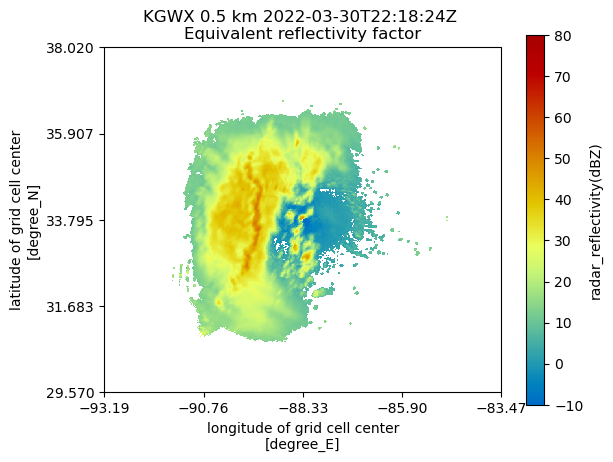

In [8]:
gdisplay.plot_grid("REF", 2, vmin=-10, vmax = 80, 
                     cmap="pyart_HomeyerRainbow", 
                     
                    )

In [89]:
xgs = xr.merge(grids)

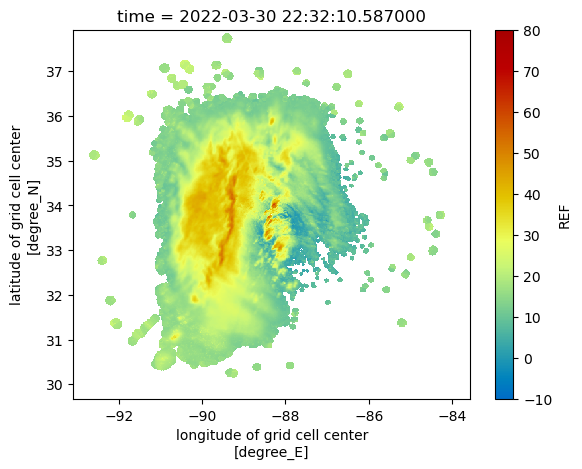

In [90]:
xgs.REF[4].max('z').plot(x='lon', y='lat', vmin=-10, vmax = 80, 
                     cmap="pyart_HomeyerRainbow", )

In [91]:
def rain_rate(ds, dbz, a=300.0, b=1.4):
    """Calculates the inverse of input decibel values
    Convert to rain rate using Marshall Palmer Relation
    """
    Z = 10.0 ** (ds[dbz] / 10.0)
    return  (Z / a) ** (1.0 / b)

In [93]:
rain = rain_rate(xgs, dbz="REF")
new_time = pd.to_datetime(rain['time'].astype("str"))
ds = rain.assign_coords({'time': new_time})
ds = ds.swap_dims({'x':'lon', 'y':'lat'})

In [107]:
ds.name = "Rain"
ds.attrs['units'] = "mm/h"

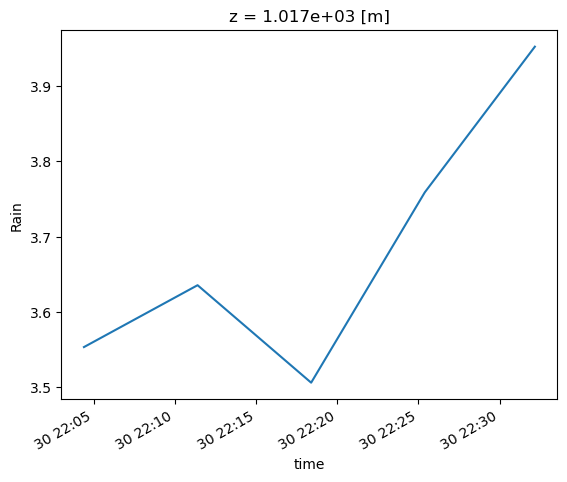

In [108]:
ds.sel(z='1000', method='nearest').sel(lat = slice(-31,36), lon=slice(-90, -88)).mean(['lat','lon']).plot()

In [3]:
max_rng = np.ceil(radar.range['data'].max())

NameError: name 'radar' is not defined

In [137]:
350*1e3/700

500.0

In [139]:
import xarray as xr

nexrad_dir = '/depot/dawson29/data/Projects/PERiLS/obsdata/2022/NEXRAD/GRID/IOP2/KGWX/'
files = ['KGWX20220331_030405_V06.nc',
         'KGWX20220330_222523_V06.nc',
         'KGWX20220331_015720_V06.nc',
         'KGWX20220331_031736_V06.nc',
         'KGWX20220331_035633_V06.nc',
         'KGWX20220330_221124_V06.nc',
         'KGWX20220330_221824_V06.nc']

dss = xr.open_mfdataset([nexrad_dir + f for f in files], combine='by_coords')

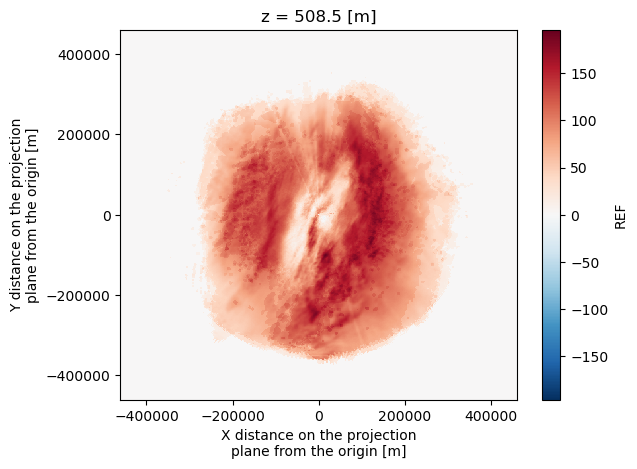

In [143]:
dss['REF'].sum("time").isel(z=2).plot()

In [6]:
nexrad_dir = '/depot/dawson29/data/Projects/PERiLS/obsdata/2022/NEXRAD/GRID/IOP2/KGWX/'
dss = xr.open_mfdataset(nexrad_dir + '*.nc', combine='by_coords')

KeyboardInterrupt: 

In [149]:
rain = rain_rate(dss, dbz="REF")
new_time = pd.to_datetime(rain['time'].astype("str"))
ds1 = rain.assign_coords({'time': new_time})
ds1 = ds1.swap_dims({'x':'lon', 'y':'lat'})
ds1.name = "Rain"
ds1.attrs['units'] = "mm/h"

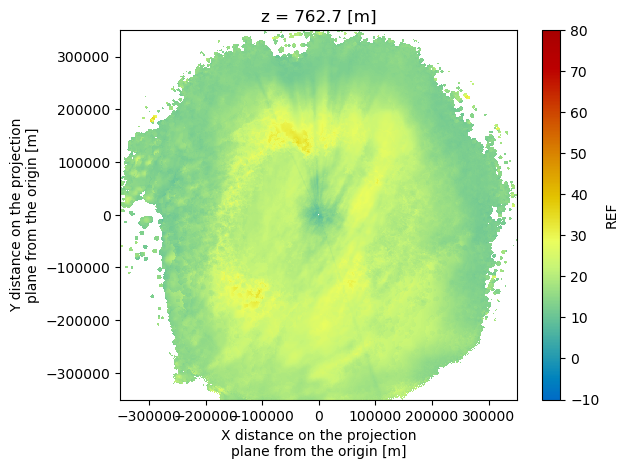

In [174]:
dss['REF'].isel(z=3).mean("time").plot(x='x', y='y', vmin=-10, vmax = 80, 
                     cmap="pyart_HomeyerRainbow", )

In [4]:
import xarray as xr

def read_grid(files):
    """
    Read Py-ART grid files and merge them into a single xarray dataset.

    Parameters
    ----------
    files : list
        A list of file paths to Py-ART grid files.

    Returns
    -------
    xgs : xarray.Dataset
        A merged xarray dataset containing the grids from all the input files.
    """
    # Initialize an empty list to store the xarray datasets.
    grids = []

    # Loop through each file and read in the Py-ART grid.
    for file in files:
        grid = pyart.io.read_grid(file)
        # Convert the Py-ART grid to an xarray dataset.
        xg = grid.to_xarray()
        # Append the xarray dataset to the list.
        grids.append(xg)

    # Merge all the xarray datasets into a single dataset.
    xgs = xr.merge(grids, )

    return xgs

In [ ]:
ds = read_grid(files)

In [5]:
nexrad_dir = '/depot/dawson29/data/Projects/PERiLS/obsdata/2022/NEXRAD/'
data_dir = 'GRID2/IOP2/KGWX/'
files = glob.glob(os.path.join(nexrad_dir, data_dir, "*.nc"))

In [6]:
# Use list comprehension to read in each file and convert to xarray dataset.
grids = [pyart.io.read_grid(file).to_xarray() for file in files]

In [10]:
ds = xr.concat(grids, dim='time')

<xarray.Dataset>
Dimensions:  (time: 3, z: 60, y: 700, x: 700)
Coordinates:
  * time     (time) object 2022-03-31 01:05:37.400000 ... 2022-03-30 22:38:45...
  * z        (z) float64 0.0 254.2 508.5 762.7 ... 1.449e+04 1.475e+04 1.5e+04
    lat      (y) float64 30.69 30.7 30.71 30.72 ... 36.96 36.96 36.97 36.98
    lon      (x) float64 -91.99 -91.98 -91.97 -91.96 ... -84.69 -84.68 -84.67
  * y        (y) float64 -3.5e+05 -3.49e+05 -3.48e+05 ... 3.49e+05 3.5e+05
  * x        (x) float64 -3.5e+05 -3.49e+05 -3.48e+05 ... 3.49e+05 3.5e+05
Data variables:
    REF      (time, z, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    VEL      (time, z, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    ZDR      (time, z, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    ROI      (time, z, y, x) float32 1.296e+04 1.294e+04 ... 1.369e+04 1.371e+04

In [22]:
# Use xarray's open_mfdataset function to combine the list of datasets into a single xarray dataset.
ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')

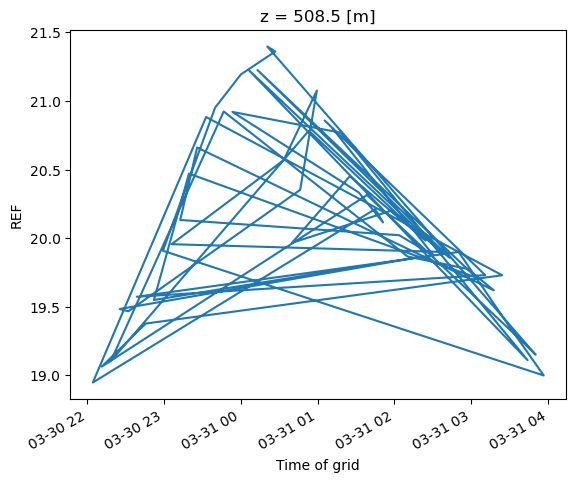

In [30]:
ds['REF'].isel(z=2).mean(['x','y']).plot()

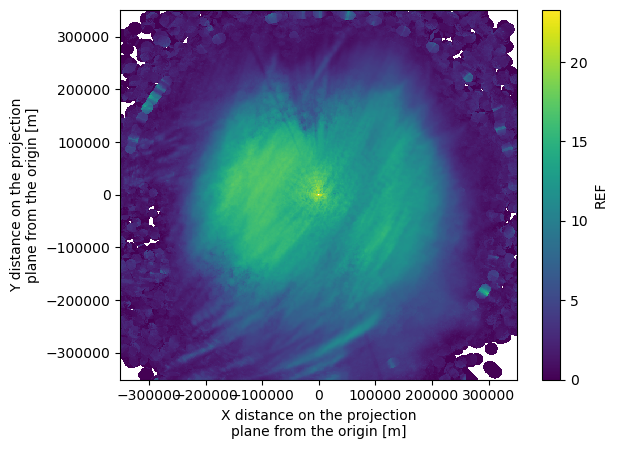

In [28]:
ds['REF'].max("z").std("time").plot()

In [96]:
filess = glob.glob(kgwx+"*")

In [117]:
# import required libraries
import xarray as xr

kgwx = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/NEXRAD/GRID_DASK/IOP2/KGWX/"
filess = glob.glob(kgwx+"*")

# loop through first two files in filess
for file in filess:
    # extract filename from file path and print it
    filename = file.split("/")[-1]
    print(f"Processing file: {filename}")
    
    # open the file as an xarray dataset and print its dimensions
    ds = xr.open_dataset(file)
    print(f"Dimensions of {filename}: {ds.dims}")
    
#     # print variable names in the dataset
#     print(f"Variables in {filename}: {list(ds.variables.keys())}")
    
    print(f"\n")


Processing file: KGWX20220331_010537_V06.nc
Dimensions of KGWX20220331_010537_V06.nc: Frozen({'time': 1, 'x': 721, 'y': 721, 'z': 61, 'nradar': 1})


Processing file: KGWX20220331_031051_V06.nc
Dimensions of KGWX20220331_031051_V06.nc: Frozen({'time': 1, 'x': 721, 'y': 721, 'z': 61, 'nradar': 1})


Processing file: KGWX20220330_223845_V06.nc
Dimensions of KGWX20220330_223845_V06.nc: Frozen({'time': 1, 'x': 721, 'y': 721, 'z': 61, 'nradar': 1})


Processing file: KGWX20220331_025006_V06.nc
Dimensions of KGWX20220331_025006_V06.nc: Frozen({'time': 1, 'x': 721, 'y': 721, 'z': 61, 'nradar': 1})


Processing file: KGWX20220331_033052_V06.nc
Dimensions of KGWX20220331_033052_V06.nc: Frozen({'time': 1, 'x': 721, 'y': 721, 'z': 61, 'nradar': 1})


Processing file: KGWX20220331_035633_V06.nc
Dimensions of KGWX20220331_035633_V06.nc: Frozen({'time': 1, 'x': 721, 'y': 721, 'z': 61, 'nradar': 1})


Processing file: KGWX20220330_225909_V06.nc
Dimensions of KGWX20220330_225909_V06.nc: Frozen({'time'

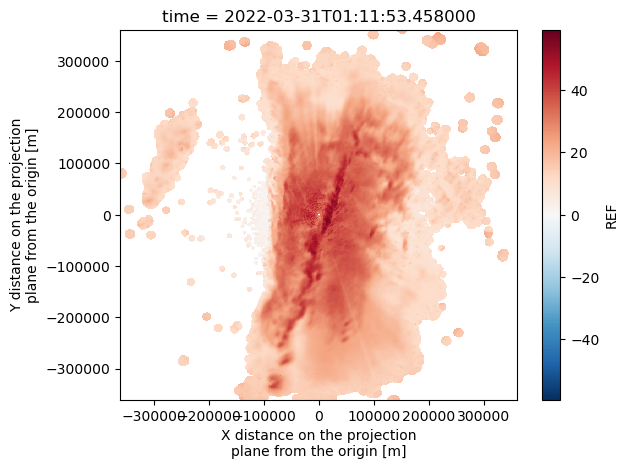

In [124]:
ds['REF'].max('z').plot()

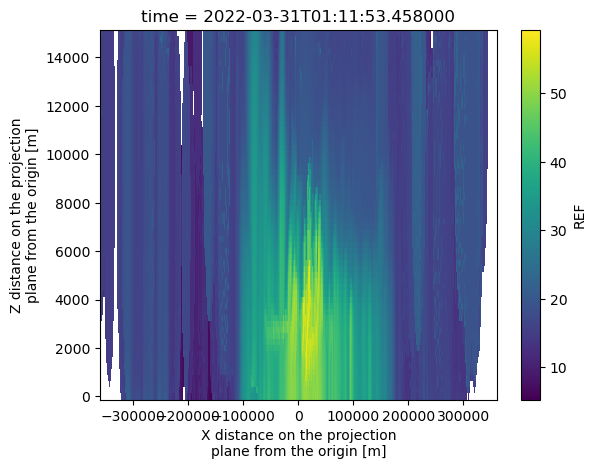

In [125]:
ds['REF'].max('y').plot()

In [7]:
nssl = pd.read_csv("/depot/dawson29/data/Projects/PERiLS/obsdata/2022/scripts/NSSL_LIDAR/NSSL_Lidar_MW41_output_20220322_153042.csv", 
                   header=2)

In [26]:
nssl['Date-Time'] = pd.to_datetime(nssl['Date-Time'].str.strip('[]'), format='%Y-%m-%dT%H:%M:%S.%f')

In [28]:
nssl.set_index('Date-Time', inplace=True)

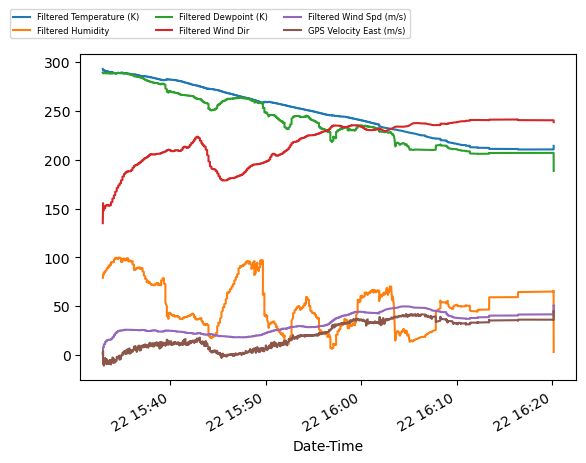

In [42]:
ax = nssl[['Filtered Temperature (K)', 'Filtered Humidity',
       'Filtered Dewpoint (K)', 'Filtered Wind Dir',
       'Filtered Wind Spd (m/s)', 'GPS Velocity East (m/s)']].plot()
ax.legend(loc='upper left', bbox_to_anchor=(-0.15, 1.15), ncol=3, fontsize=6)

In [346]:
# Submit sbatch script
!sbatch sbatch_parallel_gridding.sbatch

Submitted batch job 25573806


In [348]:
job = 25573806

In [349]:
!squeue -j $job

JOBID        USER      ACCOUNT      NAME             NODES   CPUS  TIME_LIMIT ST TIME
25573806     syed44    dawson29     sbatch_parallel_     4    400  3-00:00:00  R 0:15


In [351]:
# !scancel $job

In [377]:
!squeue -A dawson29

JOBID        USER      ACCOUNT      NAME             NODES   CPUS  TIME_LIMIT ST TIME
25571806     jiang703  dawson29     OnDemand/Noteboo     1     64    12:00:00  R 1:23:54
25514127     syed44    dawson29     OnDemand/Noteboo     1     16  5-00:00:00  R 2-06:53:17
25573806     syed44    dawson29     sbatch_parallel_     4    400  3-00:00:00  R 4:49


In [378]:
!ls -lt /depot/dawson29/data/Projects/PERiLS/obsdata/2022/GRID/IOP2/KGWX/

total 0


In [379]:
!tail parallel_gridding.out

/depot/dawson29/data/Projects/PERiLS/apps/perils/lib/python3.10/site-packages/pyart/correct/region_dealias.py:287: UserWarning: Velocities outside of the Nyquist interval found in sweep 16.
  warnings.warn(msg, UserWarning)
/depot/dawson29/data/Projects/PERiLS/apps/perils/lib/python3.10/site-packages/pyart/correct/region_dealias.py:287: UserWarning: Velocities outside of the Nyquist interval found in sweep 13.
  warnings.warn(msg, UserWarning)
/depot/dawson29/data/Projects/PERiLS/apps/perils/lib/python3.10/site-packages/pyart/correct/region_dealias.py:287: UserWarning: Velocities outside of the Nyquist interval found in sweep 14.
  warnings.warn(msg, UserWarning)
/depot/dawson29/data/Projects/PERiLS/apps/perils/lib/python3.10/site-packages/pyart/correct/region_dealias.py:287: UserWarning: Velocities outside of the Nyquist interval found in sweep 15.
  warnings.warn(msg, UserWarning)
/depot/dawson29/data/Projects/PERiLS/apps/perils/lib/python3.10/site-packages/pyart/correct/region_deali

In [92]:
import warnings
warnings.filterwarnings("ignore")
import pyart
import numpy as np
from pyart.retrieve import get_freq_band
from matplotlib import pyplot as plt
import glob, os
from datetime import datetime
import time
import sys



def _drop_fields(radar):
    fields_to_drop = ["PURPLE_HAZE"]
    for field in fields_to_drop:
        if field in radar.fields:
            del radar.fields[field]

    return radar


#function to dealiase the Doppler velocity
def dealiase(radar, vel_name='velocity', gatefilter=None, method="unwrap"):
    '''
    Dealias Doppler velocities using Py-ART.
    method : str
        Method to use for the dealiasing. Can be 'unwrap' or 'region'.
    '''
    # Create a GateFilter if one was not provided
    if gatefilter is None:
        gatefilter = pyart.correct.GateFilter(radar)
        gatefilter.include_above("REF", 0)
        gatefilter.exclude_masked('REF')
        gatefilter.exclude_invalid('REF')
        gatefilter.exclude_transition()
    # Dealias Doppler velocities using the selected method
    if method == "unwrap":
        corr_vel = pyart.correct.dealias_unwrap_phase(radar, vel_field=vel_name,
                                                      keep_original=False, gatefilter=gatefilter)
    elif method == "region":
        corr_vel = pyart.correct.dealias_region_based(radar, vel_field=vel_name,
                                                      keep_original=False, gatefilter=gatefilter)
    # Add the dealiased Doppler velocities to the radar object
    radar.add_field(vel_name, corr_vel, replace_existing=True)
    return radar


def filter_data(radar, refl_field, vel_field, dealias_method="region"):
    '''Remove noise based on velocity texture,snr, and rhohv, and mask all the fields'''
    # Drop some fields
    radar = _drop_fields(radar)
    # Align radar coords
    radar.scan_type = b'ppi'
    # Dealias
    radar = dealiase(radar, vel_name=vel_field, gatefilter=None, method=dealias_method)
    return radar


def get_nexrad_data_files(start_time: str, end_time: str) -> list:
    '''start_time: str ('YYYYMMDDHHMMSS')
       end_time: str ('YYYYMMDDHHMMSS')'''
    
    start_datetime = datetime.strptime(start_time, '%Y%m%d%H%M%S')
    end_datetime = datetime.strptime(end_time, '%Y%m%d%H%M%S')
    
    nexrad_dir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/NEXRAD/"
    data_files = []
    for iop in ["IOP2"]:
        for radar_name in ['KGWX']:
            data_files.extend(sorted(glob.glob(f"{nexrad_dir}{iop}/{radar_name}/*V06.nc")))
    
    data_files_filtered = []
    for file in data_files:
#         print(file.split('/')[-1].split("KGWX")[1].split("_V")[0])
        file_datetime_str = file.split('/')[-1].split("KGWX")[1].split("_V")[0]
        file_datetime = datetime.strptime(file_datetime_str, '%Y%m%d_%H%M%S')
        if start_datetime <= file_datetime < end_datetime:
            data_files_filtered.append(file)
    
    print("Available files: ", len(data_files_filtered))
#     for file in data_files_filtered:
#         print(file.split("/")[-1])
        
    return data_files_filtered


import os
import pyart
import multiprocessing as mp

# Define a function that takes a file name and writes the GRID file
def process_file(nexrad_dir, rfile):
    print(f'Reading file: {rfile.split("/")[-1]}')
    radar = pyart.io.read(rfile)
    radar = filter_data(radar, "DBZ", "VEL")
    max_rng = 200.0*1e3 # np.ceil(radar.range['data'].max())
    grid = pyart.map.grid_from_radars(radar,(61,801,801),
                       ((0.,15e3),(-max_rng, max_rng),(-max_rng, max_rng)), 
                                       weighting_function='Barnes2',
                                      fields=['REF', 'VEL', 'ZDR', "RHO"])

    print(f'Deleting: {rfile.split("/")[-1]}')
    del radar

    # Extract the NEXRAD file number from the file name
    file_number = rfile.split('NEXRAD')[-1]

    # Construct the full path to the GRID file using os.path.join()
    grid_file_path = os.path.join(nexrad_dir, f'GRID{file_number}')
    os.makedirs(grid_file_path, exist_ok=True)
    print(f'Saving Grid: {rfile.split("/")[-1]}')
    # Write the GRID file using pyart.io.write_grid()
    pyart.io.write_grid(filename=grid_file_path, grid=grid)


def process_file_wrapper(args):
    return process_file(*args)

In [209]:
nexrad_dir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/GRID/"
data_files = get_nexrad_data_files("20220330220000", "20220331040000")

Available files:  54


In [6]:
# Create a pool of worker processes with 100 CPUs
pool = mp.Pool(processes=100)

# Map the data files to the process_file function to process them in parallel
results = pool.map(process_file_wrapper, [(nexrad_dir, f) for f in data_files[:1]])

# Close the pool of worker processes
pool.close()
pool.join()

Reading file: KGWX20220330_220424_V06.nc
Deleting: KGWX20220330_220424_V06.nc
Saving Grid: KGWX20220330_220424_V06.nc


PermissionError: [Errno 13] Permission denied: b'/depot/dawson29/data/Projects/PERiLS/obsdata/2022/GRID/GRID/IOP2/KGWX/KGWX20220330_220424_V06.nc'

In [267]:
!ls -lt /depot/dawson29/data/Projects/PERiLS/obsdata/2022/GRID/

total 1
drwxrws---+ 3 syed44 dawson29-data 4096 Jun  1 15:55 IOP2


In [269]:
!ls /depot/dawson29/data/Projects/PERiLS/obsdata/2022/GRID/IOP2/KGWX/

In [ ]:
print(f'Deleting: {rfile.split("/")[-1]}')

# Extract the NEXRAD file number from the file name
file_number = rfile.split('NEXRAD')[-1]

# Construct the full path to the GRID file using os.path.join()
grid_file_path = os.path.join(nexrad_dir, f'{file_number}')
os.makedirs(grid_file_path, exist_ok=True)
print(f'Saving Grid: {rfile.split("/")[-1]}')

In [19]:
nexrad_dir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/"
data_files = get_nexrad_data_files("20220330220000", "20220331040000")

Available files:  54


In [21]:
for rfile in data_files[:1]:
    print(f'Deleting: {rfile.split("/")[-1]}')
    # Extract the NEXRAD file number from the file name
    file_number = rfile.split('NEXRAD')[-1]
    print(f'File Number: {file_number}')
    # Construct the full path to the GRID file using os.path.join()
    grid_file_path = os.path.join(nexrad_dir, f'GRID{file_number}')
    # os.makedirs(grid_file_path, exist_ok=True)
    print(f'Grid File Path: {grid_file_path}')
    print(f'Saving Grid: {rfile.split("/")[-1]}')
    # Write the GRID file using pyart.io.write_grid()

Deleting: KGWX20220330_220424_V06.nc
File Number: /IOP2/KGWX/KGWX20220330_220424_V06.nc
Grid File Path: /depot/dawson29/data/Projects/PERiLS/obsdata/2022/GRID/IOP2/KGWX/KGWX20220330_220424_V06.nc
Saving Grid: KGWX20220330_220424_V06.nc
